In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Correct the date format. (Complete it in the dd-mm-yyyy format)

In [3]:
#Adding the date to my Time index i.e. YYYY-MM-DD
data['Month'] = data['Month'].apply(lambda x : dt(int(x[:4]), int(x[5:]), 15))
data.head()

,Month,#Passengers
0,1949-01-15,112
1,1949-02-15,118
2,1949-03-15,132
3,1949-04-15,129
4,1949-05-15,121


In [4]:
#Setting the Month column as index. In TS the x axis or the independent variable is Time
data.set_index('Month',inplace = True)

In [5]:
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


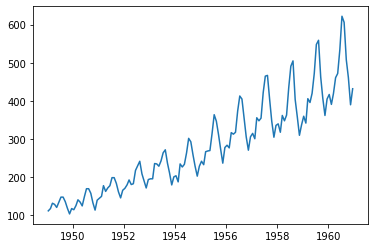

In [6]:
plt.plot(data);

This is not a stationary time series as the mean is not constant. Let us try to make it stationary

Apply transformation. Log transformation

In [7]:
ts_data = data['#Passengers']

In [8]:
ts_data_log = np.log(ts_data)

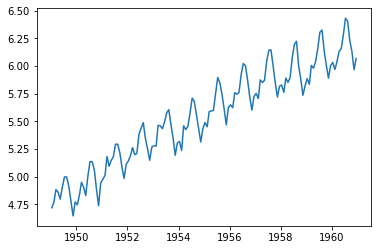

In [9]:
plt.plot(ts_data_log);

In [10]:
def test_stationarity(timeseries):
    
    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    
    
    print('Results of Dickey-Fuller Test :\n')
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[:4], index =['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] = j
    print(my_output)

Results of Dickey-Fuller Test :

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


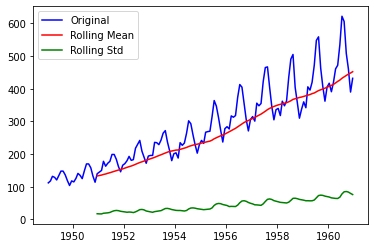

In [11]:
test_stationarity(data['#Passengers'])

The Test Statistics is not less than any of Critical Value hence 
I have to accept the Null Hypothesis i.e. TS is not stationary

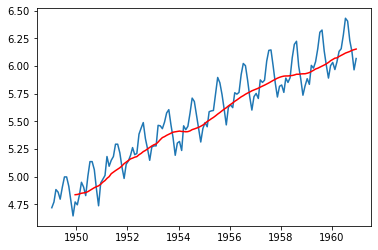

In [12]:
movingAverage = ts_data_log.rolling(window = 12).mean()
movingSTD = ts_data_log.rolling(window = 12).std()
plt.plot(ts_data_log)
plt.plot(movingAverage,color='red')

Lets try differencing

In [13]:
ts_data_log_diff = ts_data_log - movingAverage
ts_data_log_diff.head(15)

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
Name: #Passengers, dtype: float64

In [14]:
ts_data_log_diff.dropna(inplace=True)
ts_data_log_diff.head()

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
Name: #Passengers, dtype: float64

Results of Dickey-Fuller Test :

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


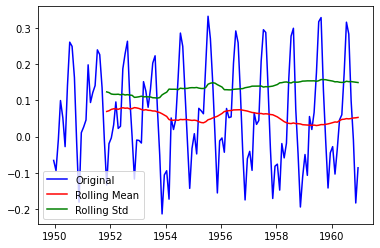

In [15]:
test_stationarity(ts_data_log_diff)

In [29]:
-3.96/np.sqrt(len(ts_data_log_diff))

-0.3433755479315515

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


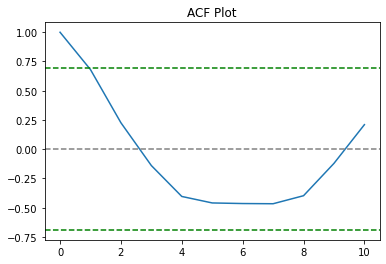

In [31]:
# Plotting the ACF curve

plt.plot(np.arange(0,11), acf(ts_data_log_diff, nlags = 10))
plt.axhline(y=0, linestyle = '--', color = 'gray')
#Confidence intervals
plt.axhline(y=-7.96/np.sqrt(len(ts_data_log_diff)), linestyle = '--', color = 'green')
plt.axhline(y=7.96/np.sqrt(len(ts_data_log_diff)), linestyle = '--', color = 'green')
plt.title('ACF Plot')
plt.show()

The curve crosses the upper confidence interval at lag 1. Thus the value of q in the ARIMA model must be either 0 or 1

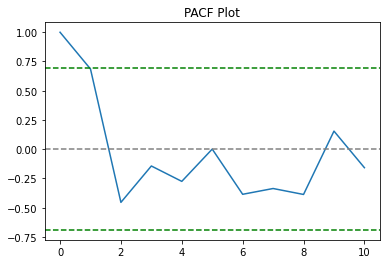

In [18]:
# Plotting the PACF curve

plt.plot(np.arange(0,11), pacf(ts_data_log_diff, nlags = 10))
plt.axhline(y=0, linestyle = '--', color = 'gray')
#Confidence intervals
plt.axhline(y=-7.96/np.sqrt(len(ts_data_log_diff)), linestyle = '--', color = 'green')
plt.axhline(y=7.96/np.sqrt(len(ts_data_log_diff)), linestyle = '--', color = 'green')
plt.title('PACF Plot')
plt.show()

The PACF curve is crossing the upper confidence interval value between 0 and 2 i.e. 1. The value of p in ARIMA model is 1.

In [55]:
my_model = ARIMA(ts_data_log, order = (0, 1, 1))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [56]:
results = my_model.fit()

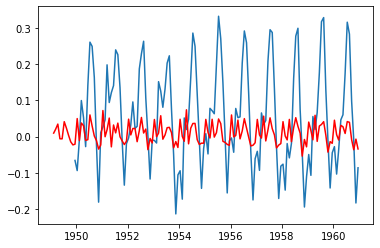

In [57]:
plt.plot(ts_data_log_diff)
plt.plot(results.fittedvalues,color='red')
plt.show()

In [58]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009726
1949-03-15    0.020485
1949-04-15    0.034537
1949-05-15   -0.005924
1949-06-15   -0.006085
dtype: float64

In [59]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009726
1949-03-15    0.030211
1949-04-15    0.064748
1949-05-15    0.058824
1949-06-15    0.052739
dtype: float64

In [60]:
predictions_ARIMA_log = pd.Series(ts_data_log.iloc[0], index = ts_data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)
predictions_ARIMA_log.head()

Month
1949-01-15         NaN
1949-02-15    4.728225
1949-03-15    4.748710
1949-04-15    4.783247
1949-05-15    4.777323
dtype: float64

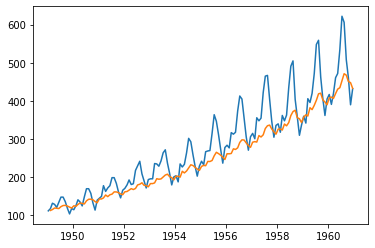

In [61]:
final_preds = np.exp(predictions_ARIMA_log)
plt.plot(ts_data)
plt.plot(final_preds)
plt.show()

In [62]:
#Calculate the RMSE
np.sqrt(sum(final_preds[1:] - ts_data[1:])**2)/len(ts_data)

30.053995612269905

In [27]:
pd.read_csv('monthly-beer-production-in-austr.csv')

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
